In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../..

/home/nassim/dev/conrl


In [3]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.sarsalambda import SarsaLambdaAgent
from src.utils import *

import itertools
import time
import numpy as np
import pandas as pd
import gym
import time
import sys
import copy
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.collections as mc

%matplotlib inline
plt.style.use('seaborn-paper')
np.set_printoptions(precision=3, linewidth=80)

## Q-Learning

In [4]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)



In [5]:
stats_q =   {
            "step":  np.zeros(num_episodes),
            "cumulative_reward":  np.zeros(num_episodes),
            "q_tables": np.zeros(shape = (num_episodes, ) + state_size + (env.action_space.n, )),
            "best_actions": []
            }

q_agent = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)

q_agent.train(env, num_episodes, stats_q)

Episode 50/500, Reward -1000.0, Average Max Reward: -1000.0, Total steps 1000.0, Epsilon: 0.72, Alpha: 0.10, Time 0.101
Episode 100/500, Reward -647.0, Average Max Reward: -910.9, Total steps 647.0, Epsilon: 0.54, Alpha: 0.10, Time 0.068
Episode 150/500, Reward -483.0, Average Max Reward: -763.8, Total steps 483.0, Epsilon: 0.37, Alpha: 0.10, Time 0.049
Episode 200/500, Reward -510.0, Average Max Reward: -339.4, Total steps 510.0, Epsilon: 0.19, Alpha: 0.10, Time 0.056
Episode 250/500, Reward -182.0, Average Max Reward: -183.5, Total steps 182.0, Epsilon: 0.01, Alpha: 0.10, Time 0.020
Episode 300/500, Reward -377.0, Average Max Reward: -712.1, Total steps 377.0, Epsilon: 0.01, Alpha: 0.10, Time 0.043
Episode 350/500, Reward -334.0, Average Max Reward: -275.7, Total steps 334.0, Epsilon: 0.01, Alpha: 0.10, Time 0.037
Episode 400/500, Reward -234.0, Average Max Reward: -172.4, Total steps 234.0, Epsilon: 0.01, Alpha: 0.10, Time 0.030
Episode 450/500, Reward -936.0, Average Max Reward: -4

## Con-RL

In [29]:
state_size = (10, 10)
env = DiscretizationWrapper(gym.make('MountainCar-v0'), state_size)

num_episodes = 500
max_step = 1000
env.env._max_episode_steps = max_step
env.spec.max_episode_steps = max_step

q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "epsilon_decay_rate": 0,
    "min_epsilon": 0.01
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

mlgng_params = {
    "ndim": 2, 
    "e_w":0.05, 
    "e_n":0.005, 
    "l":10, 
    "a":0.5, 
    "b":0.95,
    "k":1000.0, 
    "max_nodes": 5, 
    "max_age": 200
}

In [30]:
stats_cr = build_conrl_stats(num_episodes, env)

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = QLearningAgent(action_size=env.action_space.n, state_size=state_size, **q_params)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)

conrl.train(env, num_episodes, stats_cr)

#### Starting training #####


/home/nassim/dev/conrl/src/conrl.py:51: RuntimeWarning:

divide by zero encountered in double_scalars

/home/nassim/dev/conrl/src/conrl.py:52: RuntimeWarning:

divide by zero encountered in double_scalars

/home/nassim/dev/conrl/src/conrl.py:53: RuntimeWarning:

invalid value encountered in double_scalars

/home/nassim/dev/conrl/src/conrl.py:188: RuntimeWarning:

Mean of empty slice.



Episode 50/500, Average Max Reward: -758.45, Global Error: 75.08, Total steps 169.0, Discount: 0.48, Time 0.487
	 MLGNG nodes per action layer: 2 1 3
Episode 100/500, Average Max Reward: -159.98, Global Error: 110.27, Total steps 183.0, Discount: 0.23, Time 0.010
	 MLGNG nodes per action layer: 5 4 5
Episode 150/500, Average Max Reward: -128.78, Global Error: 128.87, Total steps 185.0, Discount: 0.11, Time 0.020
	 MLGNG nodes per action layer: 4 5 5
Episode 200/500, Average Max Reward: -149.06, Global Error: 89.16, Total steps 186.0, Discount: 0.05, Time 0.025
	 MLGNG nodes per action layer: 5 5 5
Episode 250/500, Average Max Reward: -184.88, Global Error: 109.81, Total steps 186.0, Discount: 0.02, Time 0.010
	 MLGNG nodes per action layer: 5 5 5
Episode 300/500, Average Max Reward: -171.92, Global Error: 90.15, Total steps 191.0, Discount: 0.01, Time 0.012
	 MLGNG nodes per action layer: 5 5 5
Episode 350/500, Average Max Reward: -171.63, Global Error: 84.47, Total steps 178.0, Discou

## Statistics

In [8]:
from src.plotting import *

act_dict = {
    0: "Push left",
    1: "No push",
    2: "Push right"
}

act_symbol = {
    0:  "o",
    1: "^",
    2: "s",
}
act_color = cm.Dark2(np.linspace(0.1, 1, 3, endpoint=False))


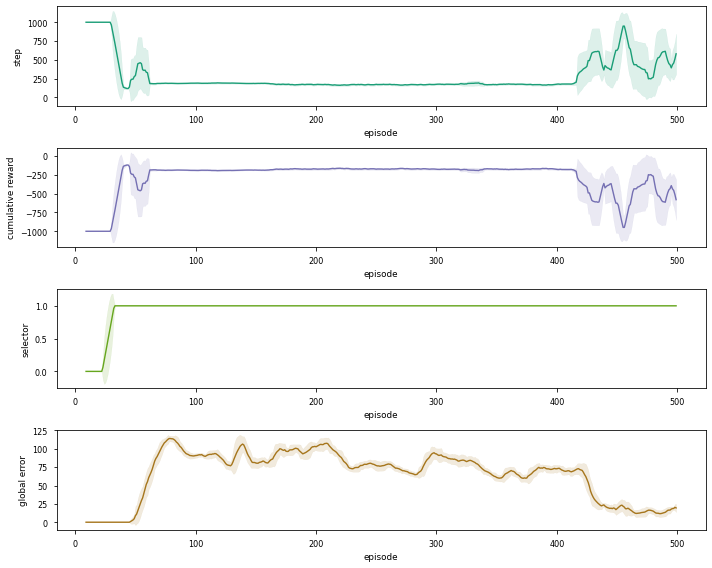

In [9]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

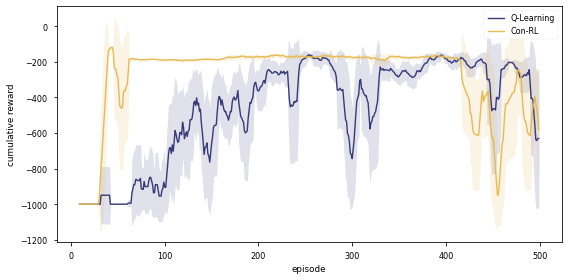

In [10]:
to_plot = ["cumulative_reward"]
plot_stats_comparison({
    "Q-Learning": {key: value for key, value in stats_q.items() if key in to_plot}, 
    "Con-RL": {key: value for key, value in stats_cr.items() if key in to_plot}
},
title="",
rolling_window=10,
subplots=len(to_plot),
figsize=(8, 4))

In [11]:
tmp = stats_cr["mlgng_nodes"][80].copy()
# tmp[0:2, tmp[2]==0]+= [[0.5], [-0.5]]
# tmp[0:2, tmp[2]==2]+=[[-0.5], [0.5]]

# tmp[0:2, tmp[2]==0]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==0].shape)
# tmp[0:2, tmp[2]==2]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==2].shape)


In [27]:
nodes=np.array(
[
    [1, 3, 8, 3, 7, 9, 6, 8, 4, 3, 5, 2],
    [1, 2, 7, 4, 3, 3, 5, 5, 4, 6, 4, 9],
    [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2]
])

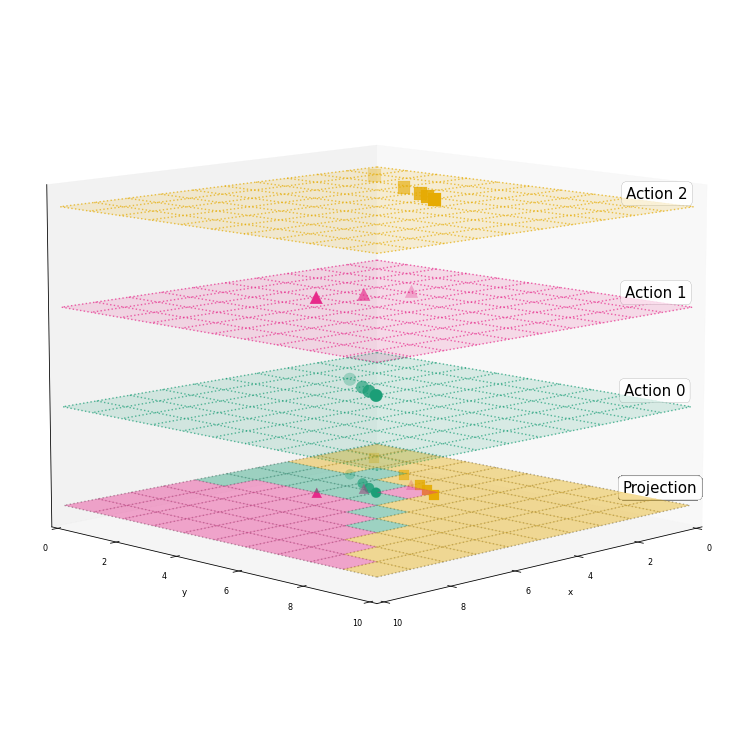

In [33]:
plot_nodes_3d(
            nodes=stats_cr["mlgng_nodes"][80],
            title="",
            policy=stats_cr["best_actions"][80],
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["x", "y", "action"])

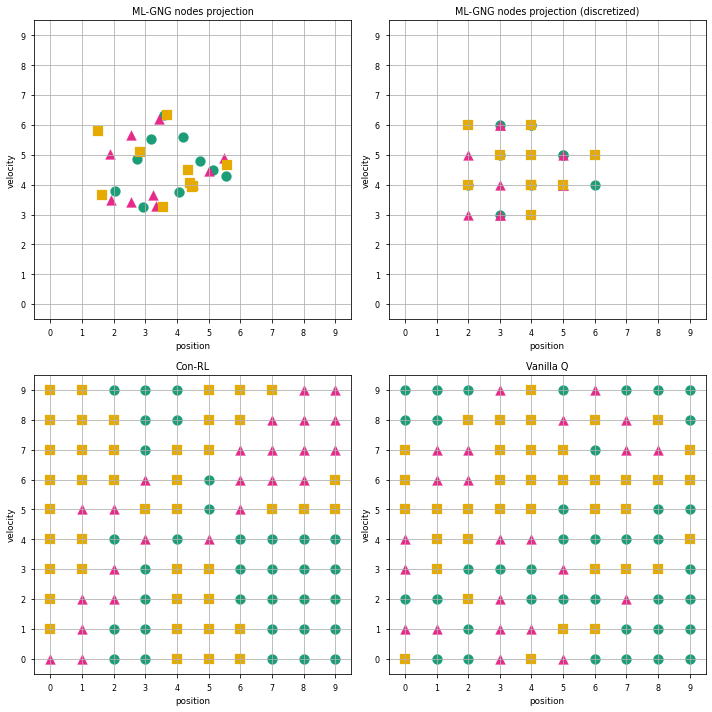

In [13]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=nodes, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes projection (discretized)",
            round=True,
            def_plot=(fig, ax[1]),)

project_nodes(nodes=conrl.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL",
            def_plot=(fig, ax[2]))

project_nodes(nodes=q_agent.get_best_actions(), 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Vanilla Q",
            def_plot=(fig, ax[3]))

fig.tight_layout()

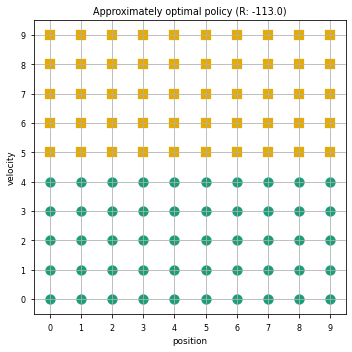

In [14]:
project_nodes(nodes=stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Approximately optimal policy (R: {})".format(stats_cr["cumulative_reward"][np.argmax(stats_cr["cumulative_reward"])]),
            figsize=(5, 5),
            round=True,)

In [15]:
tmp = stats_cr["mlgng_nodes"][70].copy()
tmp[0:2, tmp[2]==0]+= [[0.4], [-0.4]]
tmp[0:2, tmp[2]==2]+=[[-0.4], [0.4]]

tmp[0:2, tmp[2]==0]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==0].shape)
tmp[0:2, tmp[2]==2]+= np.random.normal(0, 0.3, size=tmp[0:2, tmp[2]==2].shape)


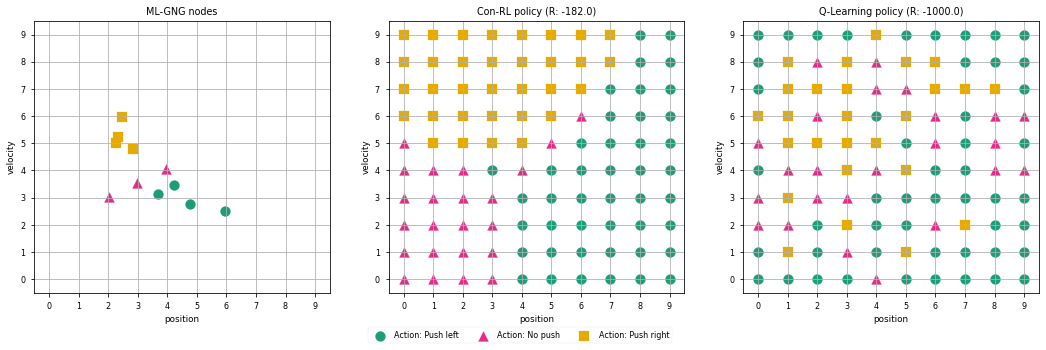

In [16]:

fig, ax = plt.subplots(ncols=3, figsize=(18, 5))
ax = ax.flatten()

ep = 70
#fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=tmp, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[1]))

project_nodes(nodes=stats_q["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Q-Learning policy (R: {})".format(stats_q["cumulative_reward"][ep]),
            round=True,
            labels=True,
            def_plot=(fig, ax[2]),
            legend=False)
fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

No handles with labels found to put in legend.


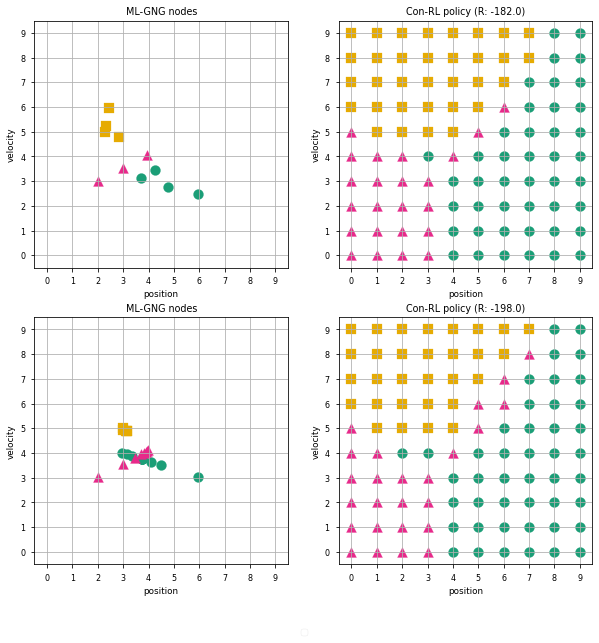

In [17]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
ax = ax.flatten()

ep = 70
#fig.suptitle("Stats@{}th episode - Reward Con-RL: {} | Vanilla Q: {}".format(ep, stats_cr["cumulative_reward"][ep], stats_q["cumulative_reward"][ep]))
project_nodes(nodes=tmp, 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[0]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[1]))

ep=110

project_nodes(nodes=stats_cr["mlgng_nodes"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="ML-GNG nodes",
            round=False,
            def_plot=(fig, ax[2]))

project_nodes(nodes=stats_cr["best_actions"][ep], 
            state_size=state_size, 
            action_names=act_dict, 
            symbols=act_symbol, 
            colors=act_color,
            axis_names=["position", "velocity"],
            title="Con-RL policy (R: {})".format(stats_cr["cumulative_reward"][ep]),
            round=True,
            def_plot=(fig, ax[3]))

fig.legend(bbox_to_anchor=(0.5, 0.04), loc='upper center', ncol=3)

In [18]:
act_symbol_plotly = {0:0, 1:5, 2:1}
act_color_plotly = act_color.copy()
act_color_plotly[:, 0:-1]=act_color_plotly[:, 0:-1]*255

In [31]:
plot_nodes_changes(stats_cr["mlgng_nodes"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr["best_actions"], 
                rewards=stats_cr["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)

In [20]:
plot_nodes_changes(stats_cr["mlgng_nodes"][160:170], 
                rewards=stats_cr["cumulative_reward"][160:170],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=1)

In [21]:
# Test MLGNG simplification from near optimal policy
good_policy = stats_cr["best_actions"][np.argmax(stats_cr["cumulative_reward"])][-1].reshape(state_size).astype(int)

stats_opt= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes)
}


for episode in range(num_episodes):
        done = False
        step = 0
        cumulative_reward = 0

        start = time.time()
        state = env.reset()

        while not done:
            action = good_policy[state]
            next_state, reward, done, _ = env.step(action)
            state = next_state
            
            cumulative_reward += reward
            step+=1

        stats_opt["cumulative_reward"][episode] = cumulative_reward
        stats_opt["step"][episode] = step 

            
        end = time.time() - start
        if (episode+1) % 50 == 0:
            print("Episode {}/{}, Average Max Reward: {}, Total steps {}, Time {:.3f}".format(
                episode+1, 
                num_episodes, 
                stats_opt["cumulative_reward"][episode-10:episode].mean(),
                stats_opt["step"][episode],
                end))

Episode 50/500, Average Max Reward: -119.4, Total steps 121.0, Time 0.011
Episode 100/500, Average Max Reward: -118.3, Total steps 116.0, Time 0.010
Episode 150/500, Average Max Reward: -119.1, Total steps 120.0, Time 0.008
Episode 200/500, Average Max Reward: -119.6, Total steps 121.0, Time 0.010
Episode 250/500, Average Max Reward: -119.9, Total steps 123.0, Time 0.014
Episode 300/500, Average Max Reward: -120.4, Total steps 122.0, Time 0.015
Episode 350/500, Average Max Reward: -119.6, Total steps 114.0, Time 0.009
Episode 400/500, Average Max Reward: -117.8, Total steps 115.0, Time 0.008
Episode 450/500, Average Max Reward: -119.9, Total steps 123.0, Time 0.010
Episode 500/500, Average Max Reward: -120.2, Total steps 122.0, Time 0.009


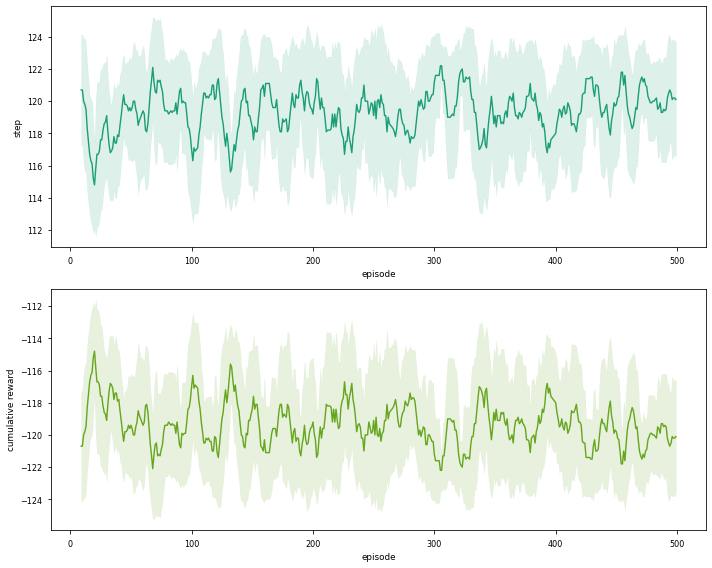

In [22]:
plot_stats(stats_opt, figsize=(10, 8))

In [23]:
class FakeSupport:
    def __init__(self, policy_table):
        self.policy_table = policy_table
        self.epsilon = 0.9
        self.epsilon_decay_rate = 0.0
        self.min_epsilon = 0.01
        self.alpha = 0.0

    def decay_param(self, param):
        decay = getattr(self, param+"_decay_rate", 0)
        value = getattr(self, param, 0)
        min_value = getattr(self, "min_"+param, 0)
        setattr(self, param, max(value-decay, min_value))

    def update(self, *args):
        pass
    
    def policy(self, state, **kwargs):
        return self.policy_table[state]
    

In [24]:
q_params = {
    "gamma": 0.9,
    "alpha": 0.1,
    "alpha_decay_rate": 0,
    "min_alpha": 0.1,
    "epsilon": 0.9,
    "min_epsilon": 0.1
}

q_params["epsilon_decay_rate"] = (q_params["epsilon"] - q_params["min_epsilon"])/(num_episodes//2)
q_params["alpha_decay_rate"] = (q_params["alpha"] - q_params["min_alpha"])/(num_episodes//2)

stats_cr2= {
        "step":  np.zeros(num_episodes),
        "cumulative_reward":  np.zeros(num_episodes),
        "selector":    np.zeros(num_episodes),
        "global_error":     np.zeros((num_episodes, env.action_space.n)),
        "mlgng_nodes":      [],
        "best_actions":     [],

}

conrl = ConRL(action_size=env.action_space.n, state_size=state_size, update_threshold=10)
support = FakeSupport(good_policy)
conrl.init_support(support)
conrl.init_mlgng(**mlgng_params)
conrl.train(env, num_episodes, stats_cr2)



#### Starting training #####


/home/nassim/miniconda3/envs/conrl/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

/home/nassim/miniconda3/envs/conrl/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



KeyError: 'nodes'

In [ ]:
to_plot = ["step", "cumulative_reward", "global_error", "selector"]

stats_to_plot = {key: value for key, value in stats_cr2.items() if key in to_plot}
stats_to_plot["global_error"] = stats_to_plot["global_error"].sum(axis=1)
plot_stats(stats_to_plot, figsize=(10, 8))

stats_to_plot = {"Global error {}".format(idx): stats_cr2["global_error"][:, idx] for idx in range(env.action_space.n)}
plot_stats(stats_to_plot, figsize=(10, 8))

plot_nodes_changes(stats_cr2["mlgng_nodes"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly,
                frequency=10)
plot_nodes_changes(stats_cr2["best_actions"], 
                rewards=stats_cr2["cumulative_reward"],
                action_names=act_dict, 
                symbols=act_symbol_plotly, 
                colors=act_color_plotly)